In [ ]:
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
from datetime import datetime
from pandas import Series
%matplotlib inline 
import warnings
from google.colab import drive
drive.mount("/content/drive")

# ignoring warnings 
warnings.filterwarnings("ignore")

# reading data from csv
# Also parsing dates as Datetime so that we can extract features like year and months later on.
# making date colum out index since we are doing Time Series analysis 
data = pd.read_csv("/content/drive/My Drive/Colab Notebooks/USD_INR Historical Data.csv", index_col='Date', parse_dates=True)

# checking current python version
print("Using python version " + sys.version)


Mounted at /content/drive
Using python version 3.7.10 (default, May  3 2021, 02:48:31) 
[GCC 7.5.0]


,Price,Open,High,Low,Change %
Date,,,,,
2020-12-30,73.127,73.370,73.398,73.135,-0.36%
2020-12-29,73.390,73.545,73.545,73.313,-0.21%
2020-12-28,73.546,73.558,73.613,73.457,0.01%
2020-12-24,73.540,73.800,73.840,73.506,-0.31%
2020-12-23,73.770,73.905,73.905,73.654,-0.11%


#### Filling missing data and Extracting features
* Adding the missing dates and filling it with last known value. 
* Extracting year, month and day from Date so that we can examin them later 

In [ ]:
# adding missing dates and filling with last known value
index = pd.date_range('01-02-2002','12-31-2020')
data = data.reindex(index, method='backfill')



# Dropping colums that we don't need
data = data.drop(['Open', 'High', 'Low', 'Change %'], axis= 1)


,Price,year,month,day
2020-12-27,73.540,2020,12,27
2020-12-28,73.546,2020,12,28
2020-12-29,73.390,2020,12,29
2020-12-30,73.127,2020,12,30
2020-12-31,73.127,2020,12,31


### Splitting Data into traing, testing and validation part

Before training or model we need to split our data into training data, validation data, and testing data 

* Training Data ( 10 years )
 * This is the data set we will use to train/ fit our models on once we have figured out the the best parameters for out model. 
* Validation Data ( 3 months )
  * This is the data set we will use to check our tentatively performace and tune our parameters
* Training - validation ( 9 years, 9 months )
 * We will train this data set first and try to figure out parameters too maximize our performance on the validation dataset. 
* Testing Data 
  * We will use two types of testing to measure performance of our models
   * predicting a month in advance ( 1 month )
   * predicting a year in advance ( 1 year )


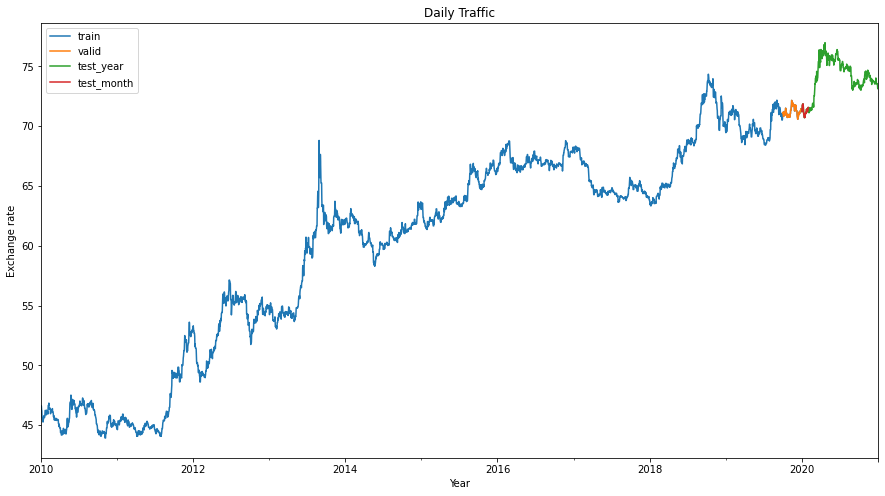

In [ ]:
train = data['01-01-2010':'01-01-2020']
valid = data['10-01-2019':'01-01-2020']
train_valid = data['01-01-2010':'10-01-2019']
test_month = data['01-01-2020':'02-01-2020']
test_year = data['01-01-2020':'01-01-2021']

## Prophet

In [ ]:
!pip install pystan==2.19.1.1
!pip install prophet
from prophet import Prophet

     |████████████████████████████████| 71kB 8.7MB/s 
     |████████████████████████████████| 51kB 7.6MB/s 
     |████████████████████████████████| 184kB 37.0MB/s 
  Created wheel for prophet: filename=prophet-1.0.1-cp37-none-any.whl size=6640246 sha256=f34b435d18bb3b4049a30d335d399c051614e544a8c28a6dd6d0296f60ba6e50
  Stored in directory: /root/.cache/pip/wheels/92/1d/02/bc0a91bd3a84e060722075d2b0b68e875e37ec7dc49451d513
Successfully built prophet
ERROR: fbprophet 0.7.1 has requirement cmdstanpy==0.9.5, but you'll have cmdstanpy 0.9.68 which is incompatible.
  Found existing installation: cmdstanpy 0.9.5
    Uninstalling cmdstanpy-0.9.5:
      Successfully uninstalled cmdstanpy-0.9.5


In [ ]:
df_train = train.copy()
df_train = df_train.rename(columns={"Price":"y"})
df_train['ds'] = df_train.index
df_train.tail()

prophet_model = Prophet().fit(df_train)

prediction_month = test_month.copy()
prediction_month['ds'] = prediction_month.index
prediction_month = prediction_month.rename(columns={"Price":"y"})
prediction_month = prediction_month.drop(['year', 'month', 'day'], axis= 1)
prediction_month = prediction_month.reset_index()
prophet_predict_month = prophet_model.predict(prediction_month)

prediction_year = test_year.copy()
prediction_year['ds'] = prediction_year.index
prediction_year = prediction_year.rename(columns={"Price":"y"})
prediction_year = prediction_year.drop(['year', 'month', 'day'], axis= 1)
prediction_year = prediction_year.reset_index()
prophet_predict_year = prophet_model.predict(prediction_year)
# prophet_predict_year.head()

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


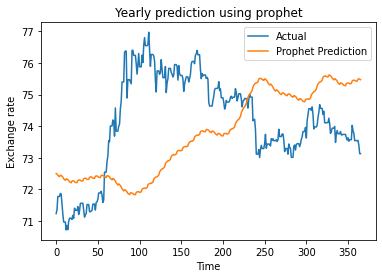

RMSE for Prophet model is: 2.0667
Mean Absolute Percent Error: 2.37%


In [ ]:
import sklearn.metrics as met
prediction_year.y.plot(label = "Actual")
prophet_predict_year.yhat.plot(label = "Prophet Prediction")
plt.xlabel('Time')
plt.title('Yearly prediction using prophet')
plt.ylabel('Exchange rate')
plt.legend(loc = 'best')
plt.show()

residuals = prediction_year.y - prophet_predict_year.yhat
rmse_sarima = round(np.sqrt(np.mean(residuals**2)),4)
mape_sarima = round(np.mean(abs(residuals/prediction_year.y)),4)

print("RMSE for Prophet model is: "+ str(rmse_sarima))
print("Mean Absolute Percent Error: " + str(mape_sarima*100) + "%")

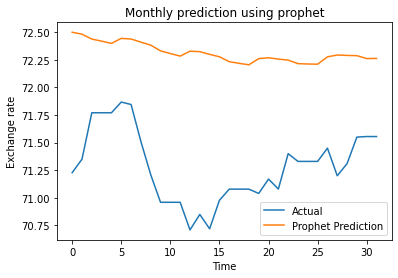

RMSE for Prophet model is: 1.0726
Mean Absolute Percent Error: 1.4500000000000002%


In [ ]:
prediction_month.y.plot(label = "Actual")
prophet_predict_month.yhat.plot(label = "Prophet Prediction")
plt.xlabel('Time')
plt.title('Monthly prediction using prophet')
plt.ylabel('Exchange rate')
plt.legend(loc = 'best')
plt.show()

residuals = prediction_month.y - prophet_predict_month.yhat
rmse_sarima = round(np.sqrt(np.mean(residuals**2)),4)
mape_sarima = round(np.mean(abs(residuals/prediction_month.y)),4)

print("RMSE for Prophet model is: "+ str(rmse_sarima))
print("Mean Absolute Percent Error: " + str(mape_sarima*100) + "%")